# Uticaj kršenja pretpostavki linearne regresije na tačnost i stabilnost regresionih modela

## Uvod

Linearna regresija predstavlja jednu od najznačajnijih i najčešće korišćenih metoda za modelovanje zavisnosti između numeričkih promenljivih. Zbog svoje interpretabilnosti, jednostavnosti implementacije i jasne teorijske osnove, široko je zastupljena u statistici, mašinskom učenju i primenjenim analizama podataka.


Međutim, teorijska opravdanost i pouzdanost linearne regresije zasnivaju se na nekoliko ključnih pretpostavki:
- postojanju linearne veze između ulaznih i izlaznih promenljivih
- nezavisnosti grešaka
- normalnosti raspodele grešaka
- jednake varijanse (homoskedastičnosti)
- kao i odsustvu jake multikolinearnosti između ulaznih atributa


U **realnim** skupovima podataka ove pretpostavke su često delimično ili potpuno narušene.


Kršenje navedenih pretpostavki može dovesti do nestabilnih procena regresionih koeficijenata, povećane varijanse modela, smanjene pouzdanosti intervala poverenja, kao i lošije generalizacije na nove podatke. Iako model može zadržati dobru vrednost standardnih metrika tačnosti (npr. RMSE ili R^2), njegova osetljivost na male promene u podacima može ukazivati na problem stabilnosti.

Upravo iz tog razloga, pored same tačnosti predikcije, važno je analizirati i stabilnost regresionih modela. Stabilnost u ovom radu podrazumeva osetljivost modela na male promene u trening podacima (npr. različite podele na trening i test skup) ili na kontrolisano narušavanje teorijskih pretpostavki. Model se smatra stabilnim ukoliko male promene u podacima dovode do relativno malih promena u performansama i procenjenim parametrima. Kao glavni kvantifikator za stabilnost može se koristiti promenljiva delta RMSE, tj. relativna promena RMSE koja je jednaka razlici novog i baznog RMSE, koju delimo sa baznim RMSE.

## Cilj projekta

Cilj ovog projekta jeste ispitivanje uticaja kršenja pretpostavki linearne regresije na tačnost i stabilnost različitih regresionih modela. Fokus će biti stavljen na poređenje standardnog **OLS** modela sa regularizovanim metodama (**Ridge** i **Lasso**), robusnim regresionim pristupima (**Huber** i **RANSAC**), kao i nelinearnim ensemble modelom **XGBoost**. Analiza će se sprovoditi kroz kontrolisane numeričke eksperimente i ponovljene evaluacije, kako bi se kvantifikovala varijabilnost performansi i osetljivost modela na sistematska odstupanja od teorijskih pretpostavki.

Na ovaj način, rad ne ispituje samo koliko su modeli tačni, već i koliko su pouzdani i stabilni u realističnim uslovima rada, gde idealne pretpostavke često nisu ispunjene.

## Dataset

U projektu će se koristiti **Energy Efficiency Dataset**, koji je dostupan u okviru [UCI Energy Efficiency Dataset](https://archive.ics.uci.edu/dataset/242/energy+efficiency) baze podataka.

Skup podataka sadrži ukupno 768 instanci i 8 ulaznih promenljivih, koje opisuju
geometrijske i energetske karakteristike zgrada:
- relativna kompaktnost
- površina
- površina zidova
- površina krovova
- ukupna visina
- orijentacija
- površina ostakljenja
- raspodela površine ostakljenja

Izlazne promenljive predstavljaju:
- **potreba za grejanjem**
- potreba za hlađenjem

Mi ćemo se fokusirati na izlaznu promenljivu **potreba za grejanjem**.

## Izrada projekta obuhvata sledeće korake:

1) Eksplorativna analiza podataka
2) Provera pretpostavki
3) Izrada regresionih modela
4) Kontrolisano narušavanje prepostavki
5) Analiza stabilnosti modela






## 1) Eksplorativna analiza podataka

### Šta je u dataset-u “problematično” za OLS pretpostavke?

Pre nego što gledamo performanse, važno je da vidimo **koje pretpostavke su realno narušene**:
- multikolinearnost (VIF i korelacije),
- normalnost reziduala (QQ plot),
- jednake varijanse / heteroskedastičnost (reziduali vs predikcije).



### 1.1 Korelacije atributa

```python
def load_and_prepare_heating_data(Path):
    df = load_energy_efficiency(data_dir)
    X, y = split_xy_heating(df)
    return df, X, y
```

```python
plot_correlation_heatmap(X, out_fig / "corr_heatmap.png")
```



<div style="text-align:center;">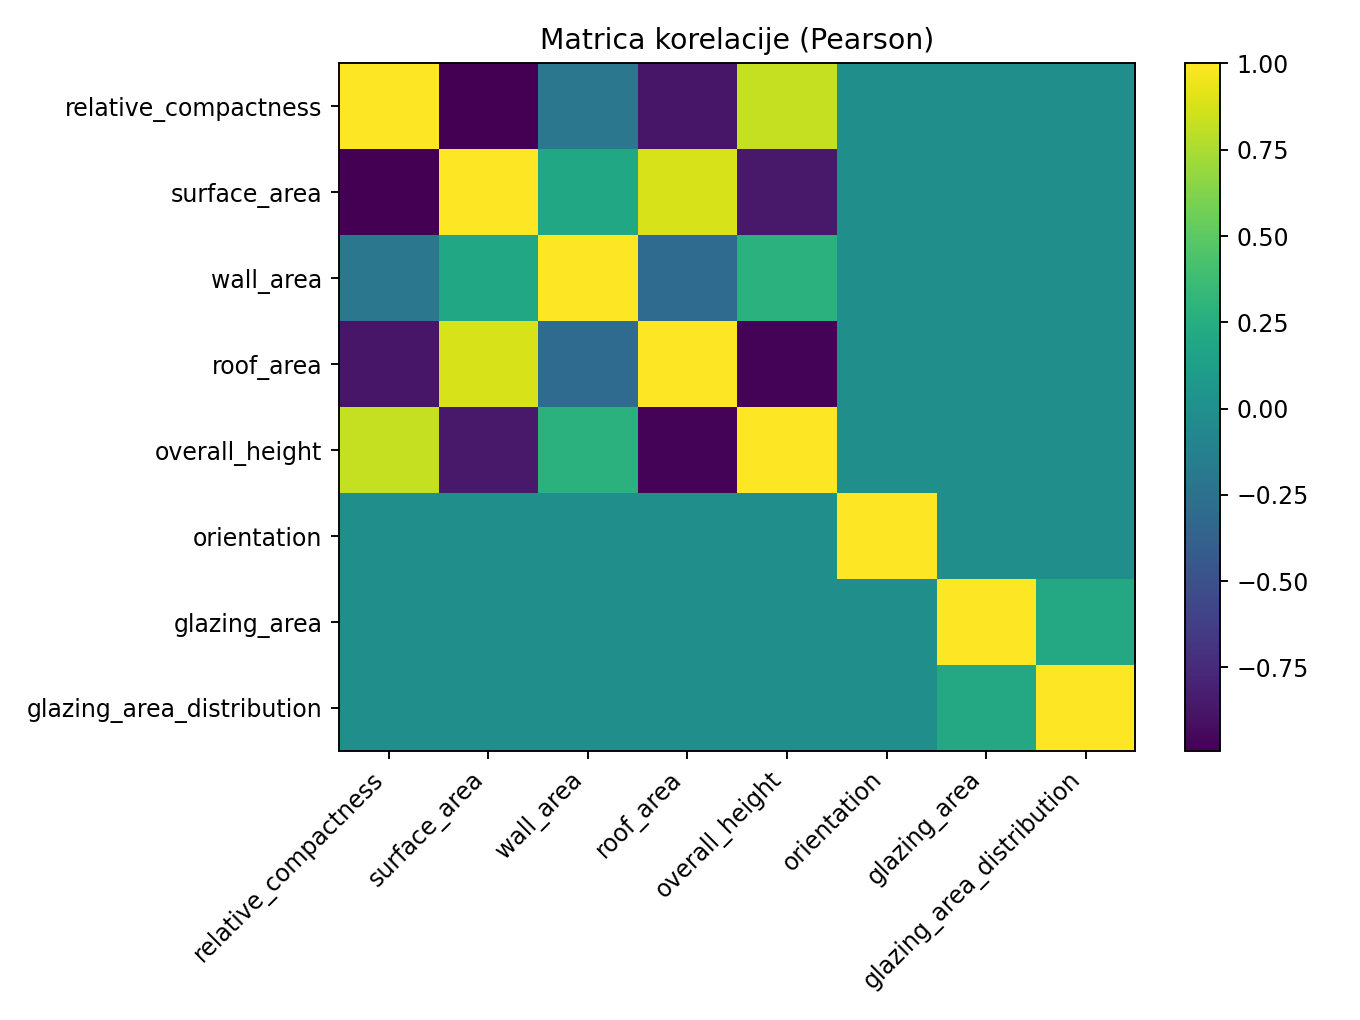<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 1: Korelaciona matrica ulaznih atributa (Heatmap).</em></div></div>

### 1.2 Multikolinearnost (VIF)
```python
# VIF (Variance Inflation Factor), kvantifikacija multikolinearnosti
vif_df = compute_vif(X)
vif_df.to_csv(out_tab / "vif.csv", index=False)
plot_vif(vif_df, out_fig / "vif.png")
```




<div style="text-align:center;">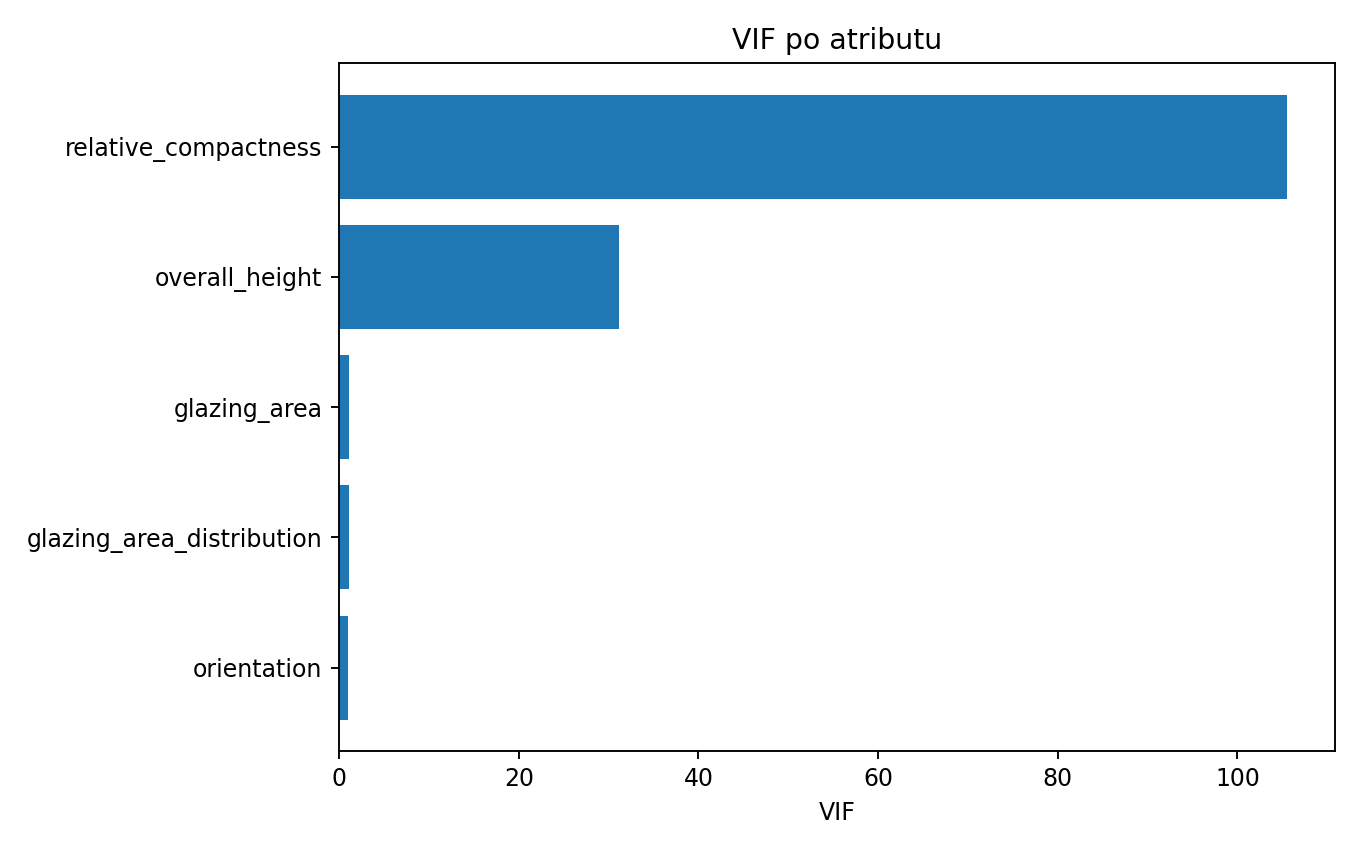<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 2: VIF vrednosti – vizuelni prikaz multikolinearnosti.</em></div></div>

### 1.3 Reziduali: nenormalnost i heteroskedastičnost(nejednaka varijansa)
```python
# OLS fit 
ols = build_ols_model()
ols.fit(X, y)
pred = ols.predict(X)
resid = y - pred

# varijansa i normalnost
plot_residuals(
    y,
    pred,
    out_fig / "residuals_vs_pred_heating.png",
    "Reziduali vs predikcije (heating)",
)
plot_qq(resid, out_fig / "qq_plot_heating.png", "QQ-plot reziduala (heating)")
```




<div style="text-align:center;">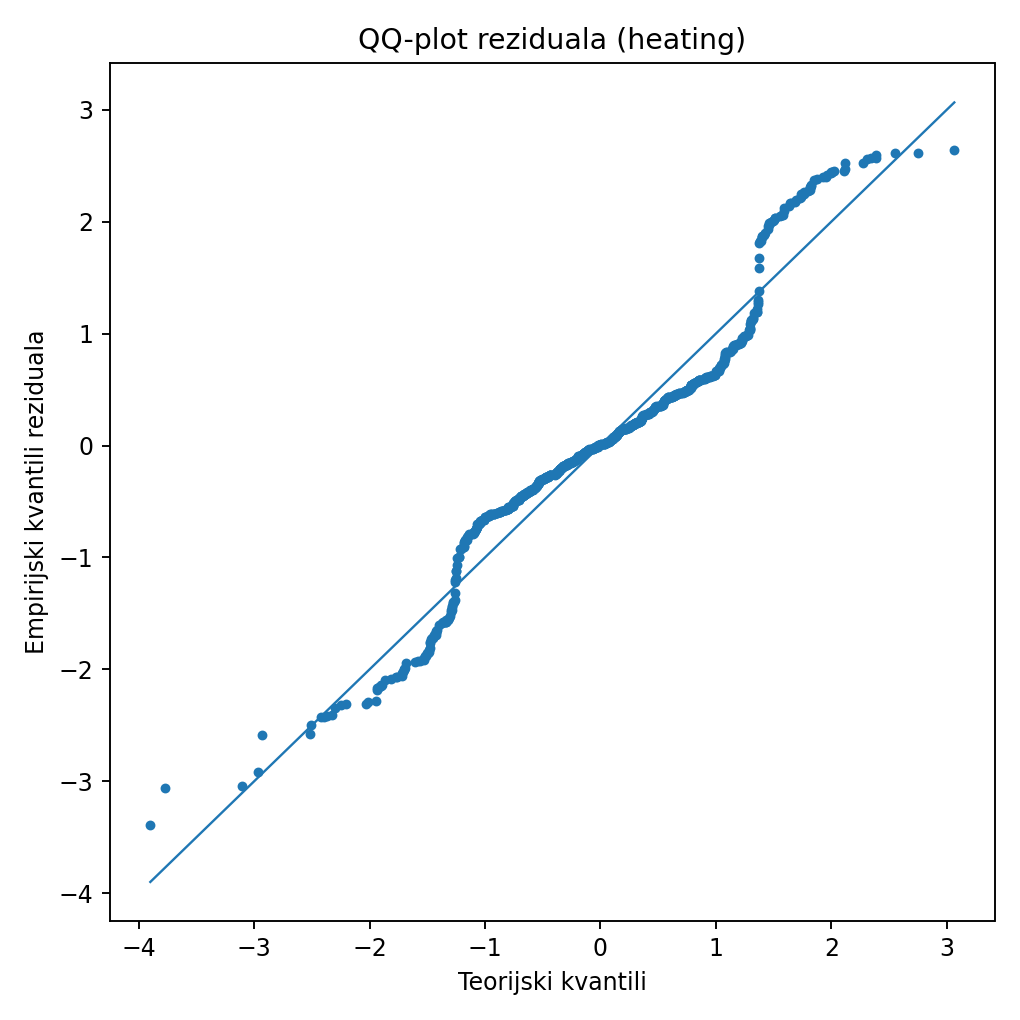<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 3: QQ-plot reziduala (indikacija nenormalnosti).</em></div></div>

<div style="text-align:center;">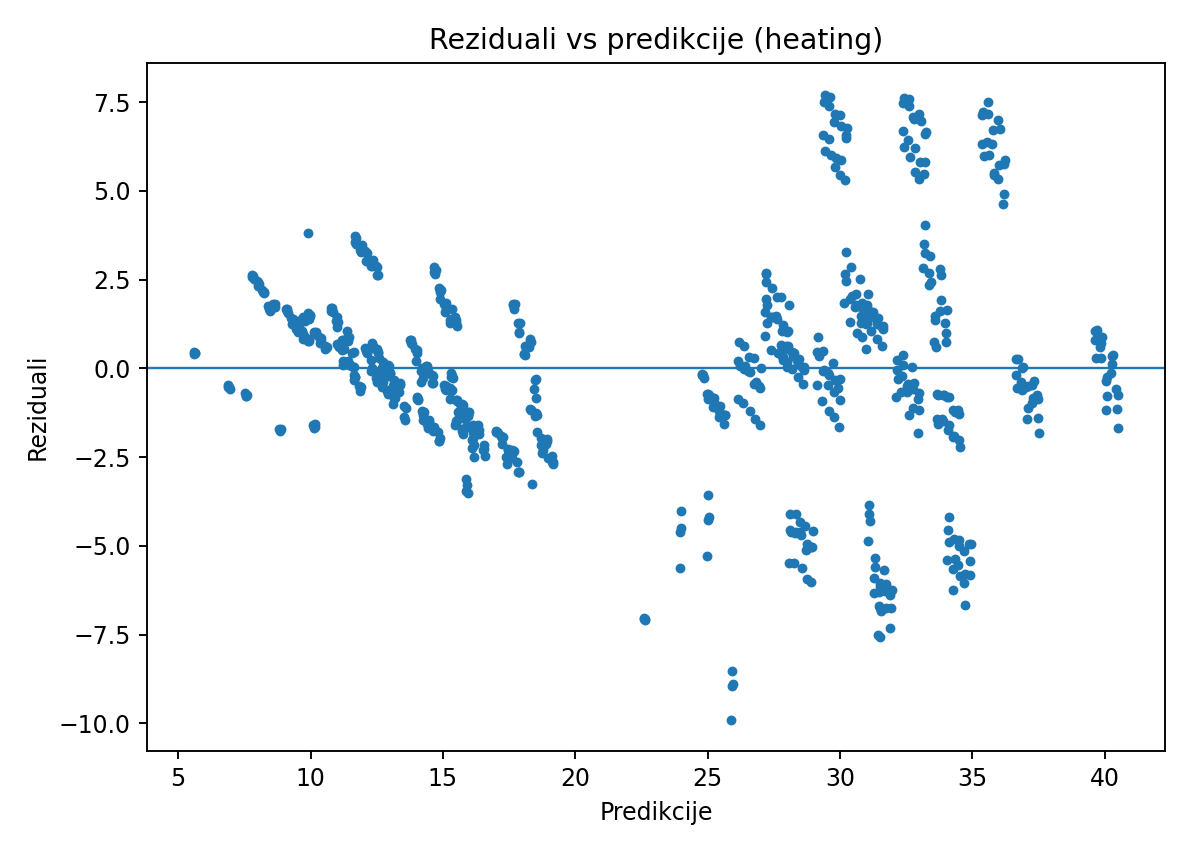<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 4: Reziduali vs predikcije (indikacija heteroskedastičnosti).</em></div></div>

### 1.4 Distribucija ulaznih podataka
```python
# Pretpostavke: linearnost
plot_linearity_grid(X, y, TARGET_COL, out_fig / "linearity_heating.png")
```




<div style="text-align:center;">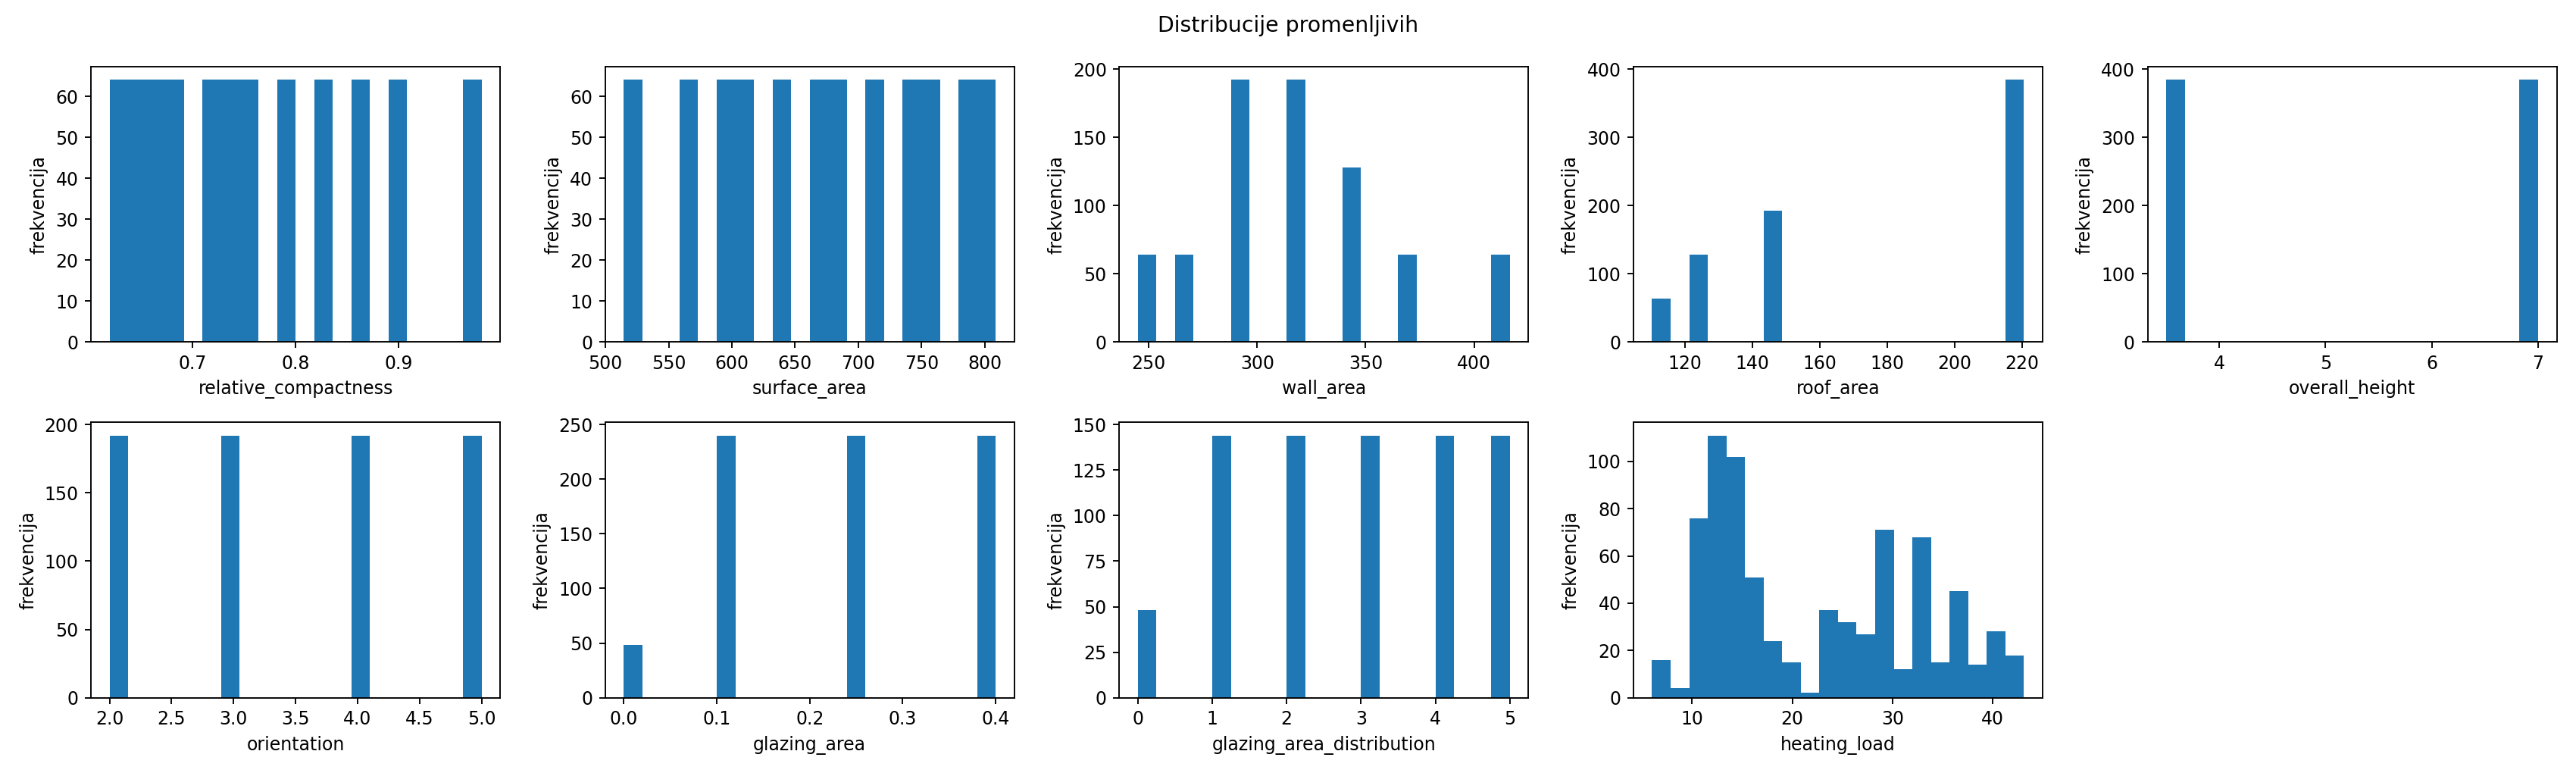<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 7: Distribucije ulaznih promenljivih (EDA).</em></div></div>

<div style="text-align:center;">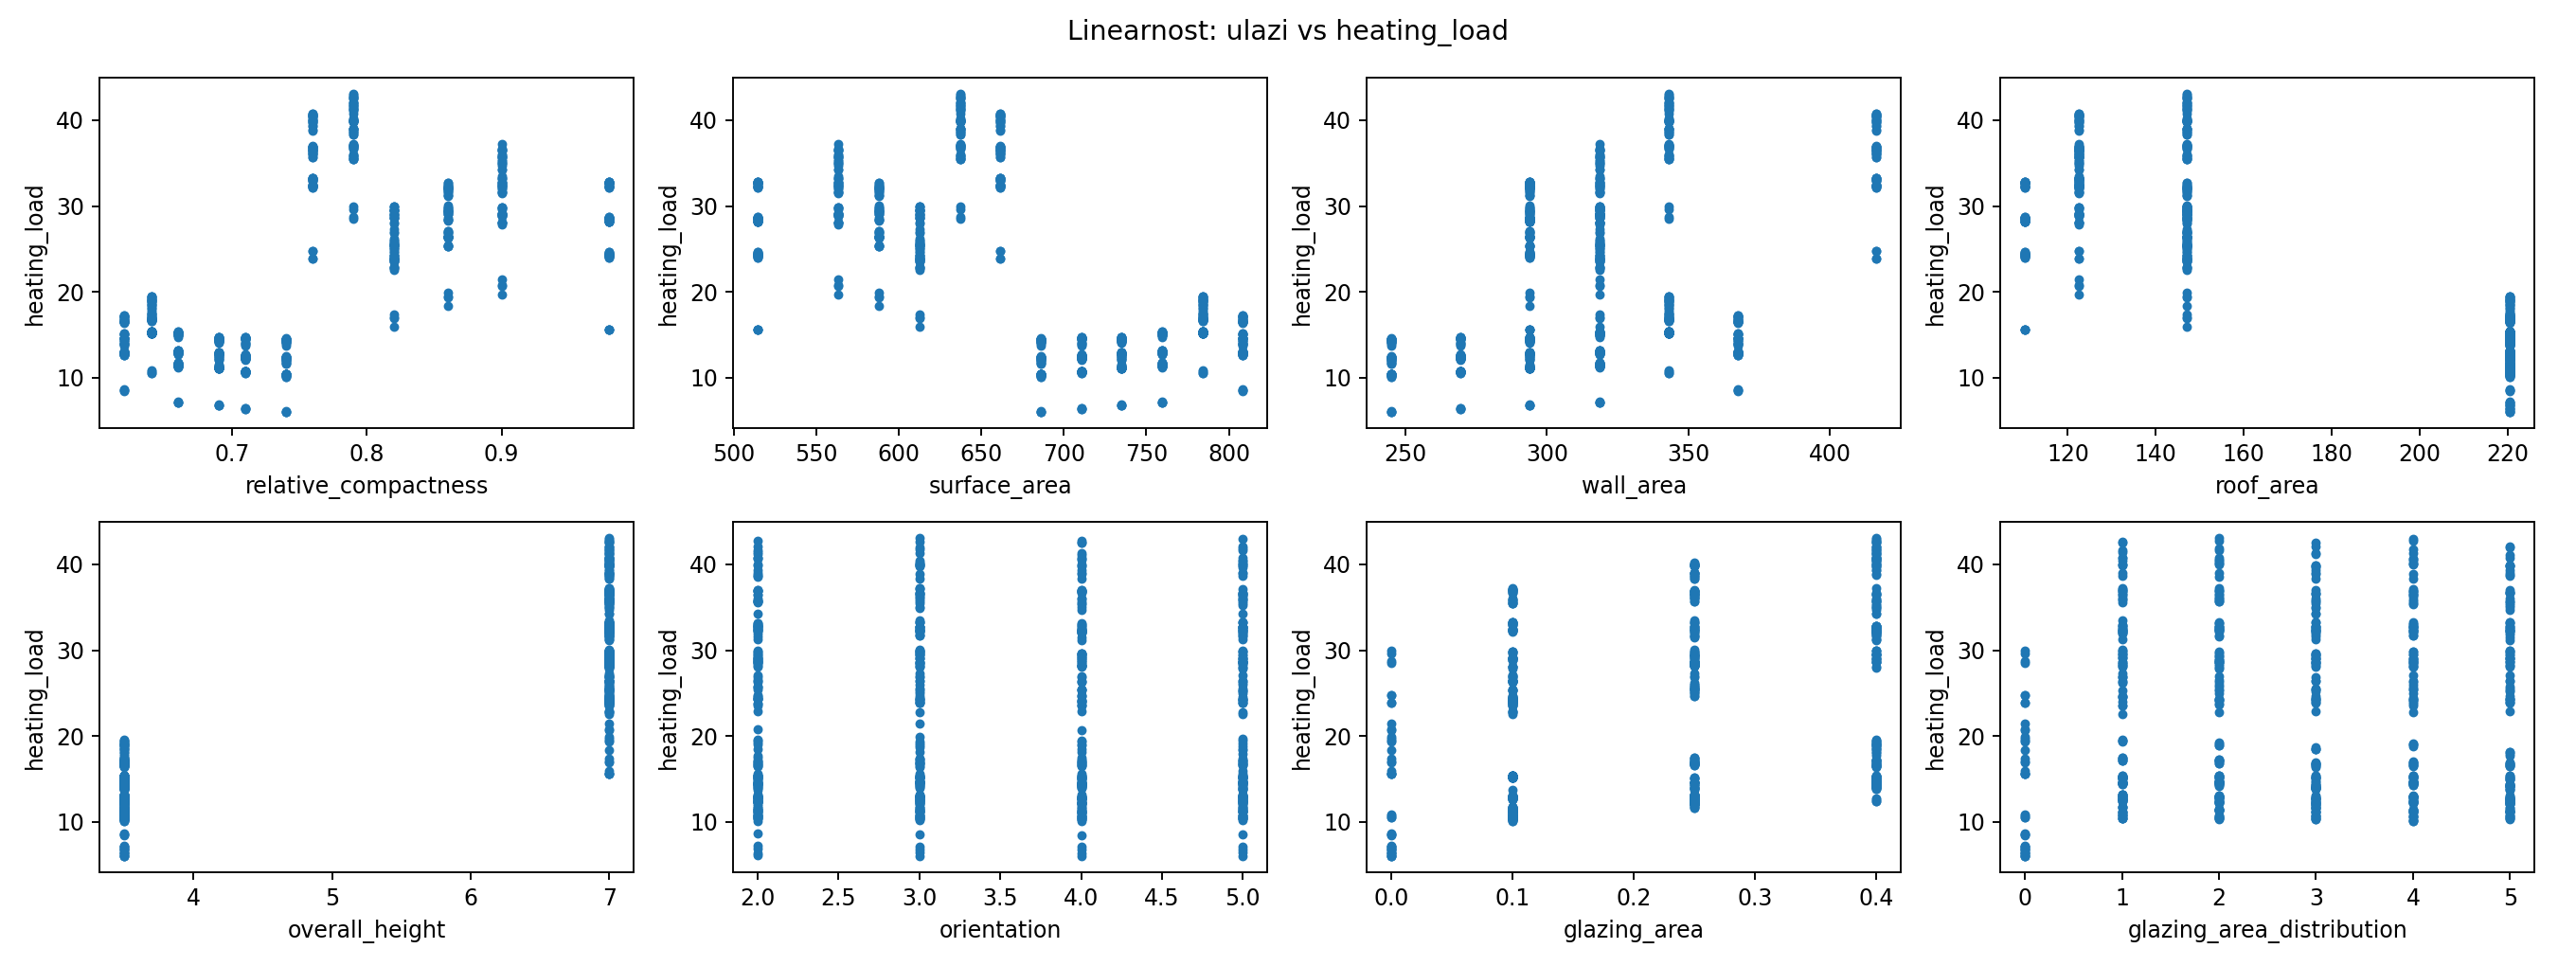<div style="font-size:0.9em; color:#555; margin-top:6px;"><em>Slika 8: Vizuelni pregled linearnosti (ulazne promenljive vs Heating Load).</em></div></div>

**Mini-zaključak (pretpostavke):**
- VIF tabela pokazuje veoma jaku multikolinearnost, što je “red flag" za stabilnost koeficijenata OLS-a.
- QQ plot i reziduali vs predikcije sugerišu odstupanja od idealnih pretpostavki (normalnost + jednake varijanse).

Zbog toga ima smisla uključiti **regularizaciju (Ridge/Lasso)** i **robusne modele (Huber/RANSAC)**, a kao kontrast i **XGBoost**.


## 2) Modeli, ponovljeni eksperimenti i interpretacija rezultata

U ovom delu fokus je na zadacima iz teksta projekta: **implementacija Ridge/Lasso/Huber/RANSAC/XGBoost**, **ponovljeni eksperimenti (N split i k-fold)**, analiza stabilnosti/robusnosti i **poređenje performansi**.


### 2.1 Učitavanje gotovih rezultata iz `outputs/tables`

U ovoj ćeliji samo učitavamo CSV tabele koje je projekat već izgenerisao (pipeline).

In [ ]:
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown

# Pretpostavka: notebook se pokrece iz korena projekta (gde je run_project.py)
ROOT = Path('.').resolve()
OUT = ROOT / 'outputs'
TAB = OUT / 'tables'

assert TAB.exists(), f"Ne nalazim {TAB}. Pokreni notebook iz foldera NANSPROJECT/" 

agg_splits = pd.read_csv(TAB / 'agg_splits_heating.csv')
agg_kfold  = pd.read_csv(TAB / 'agg_kfold_heating.csv')
coef_sum   = pd.read_csv(TAB / 'coef_summary_heating.csv') if (TAB/'coef_summary_heating.csv').exists() else None

display(agg_splits.head())
display(agg_kfold.head())

,scenario,model,mse_mean,mse_std,rmse_mean,rmse_std,rmse_median,r2_mean,r2_std,adj_r2_mean,adj_r2_std,n,rmse_iqr
0,base,XGBoost,2.120453,0.262818,1.453652,0.090361,1.463907,0.979480,0.002348,0.978348,0.002478,10,0.115296
1,base,RANSAC,8.854225,1.203410,2.969394,0.202545,2.997472,0.914205,0.012190,0.909471,0.012863,10,0.367468
2,base,OLS,8.882485,1.165989,2.974525,0.196310,3.006092,0.913928,0.011849,0.909180,0.012503,10,0.345593
3,base,Ridge,8.891828,1.154211,2.976222,0.194174,3.008953,0.913842,0.011709,0.909088,0.012355,10,0.335437
4,base,Huber,8.975567,1.388368,2.987950,0.230275,2.976020,0.913013,0.013992,0.908213,0.014764,10,0.407431


,scenario,model,mse_mean,mse_std,rmse_mean,rmse_std,rmse_median,r2_mean,r2_std,adj_r2_mean,adj_r2_std,n,rmse_iqr
0,base,XGBoost,2.121535,0.278458,1.453641,0.096970,1.480944,0.979008,0.002408,0.977847,0.002538,10,0.171523
1,base,OLS,8.687684,1.146028,2.941500,0.197939,2.958489,0.913891,0.011105,0.909127,0.011717,10,0.153725
2,base,Ridge,8.701977,1.147473,2.943943,0.197707,2.966047,0.913767,0.010968,0.908996,0.011572,10,0.169958
3,base,RANSAC,8.710482,1.128902,2.945558,0.194855,2.961566,0.913649,0.011083,0.908871,0.011695,10,0.119967
4,base,Lasso,8.787569,1.158343,2.958416,0.198167,2.986655,0.912941,0.010873,0.908125,0.011471,10,0.185138


### 2.2 Bazni scenario (N random split): ko je tačan i koliko varira?

**Slika 5** prikazuje raspodelu RMSE kroz više *random split* ponavljanja.

Kako se čita boxplot:
- **niže = tačnije** (manji RMSE)
- **uže = stabilnije** (manja varijabilnost kroz ponavljanja)


<div style="text-align:center;">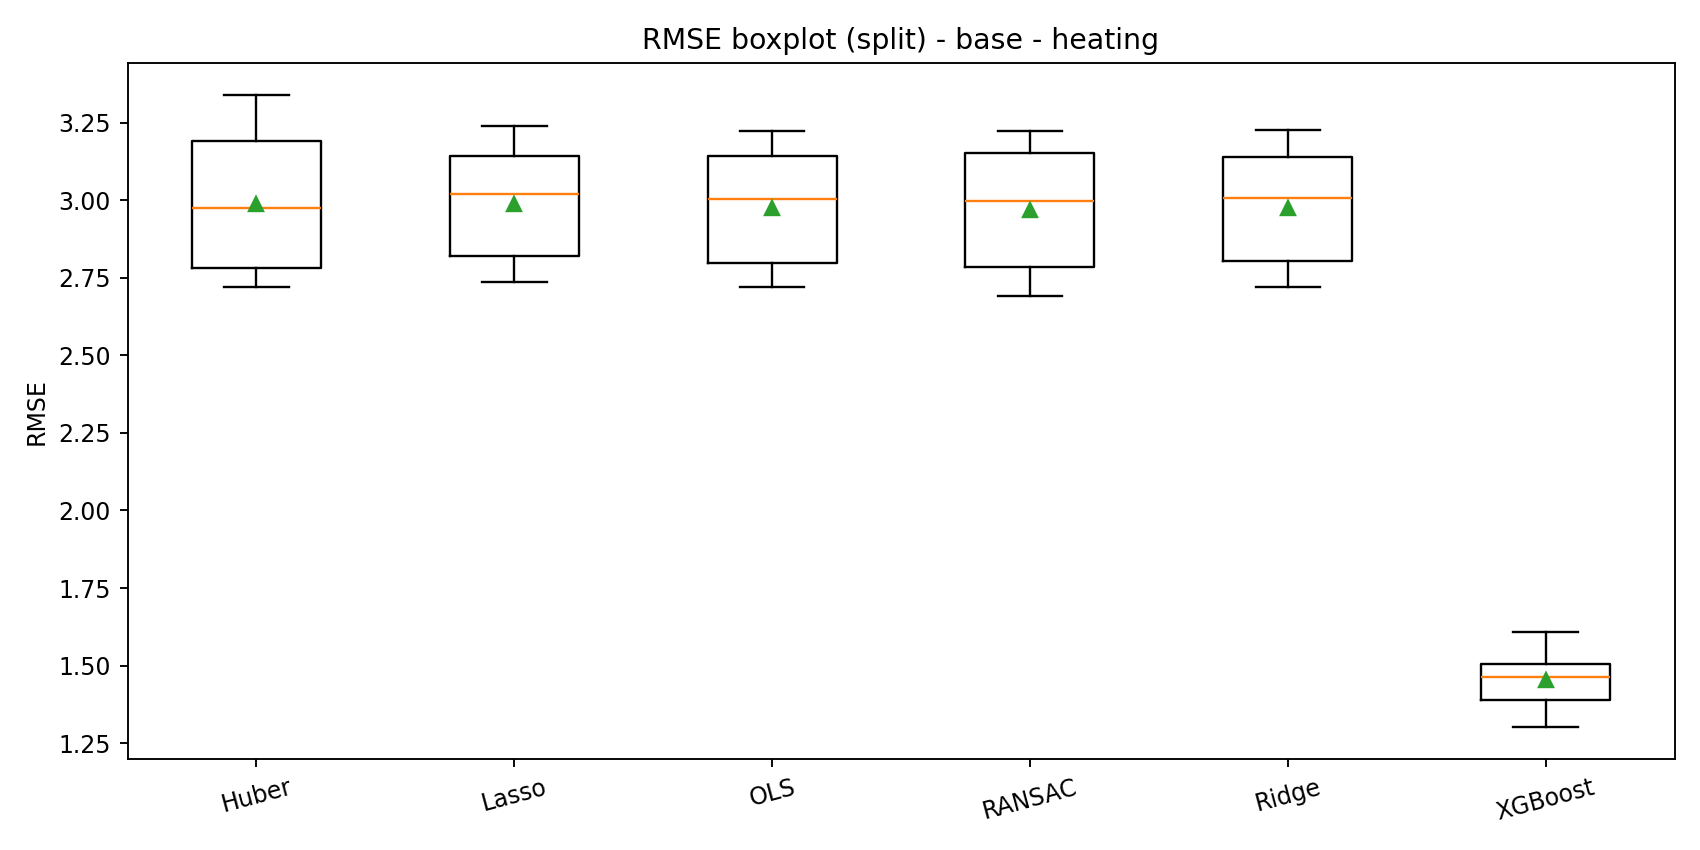</div>

**Šta očekujemo u baznom scenariju:**
- XGBoost i RANSAC često daju najbolji RMSE.
- Linearni modeli (OLS/Ridge/Lasso/Huber) su bliže jedni drugima po RMSE, ali razlike postaju jasnije kad pogledamo stabilnost i koeficijente.

### 2.3 Bazni scenario (ponovljeni k-fold): isti zaključak pod strožom evaluacijom

**Slika 6** radi istu stvar kao Slika 5, ali kroz *k-fold* (svaki deo skupa jednom bude test), što daje robusniju sliku generalizacije.

<div style="text-align:center;">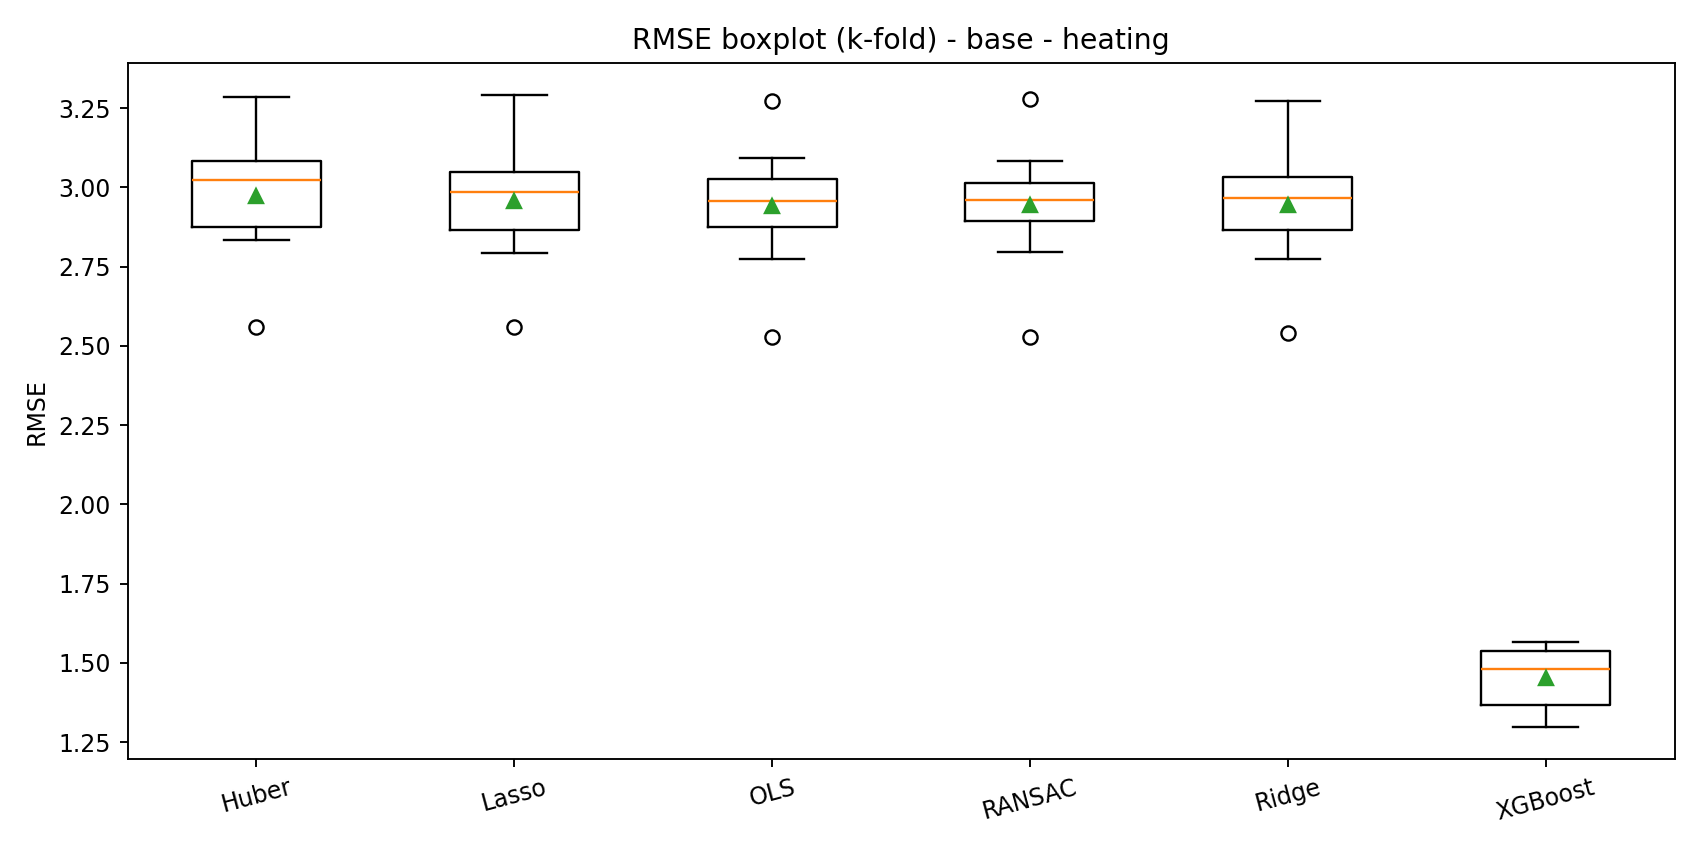</div>

**Kratak komentar:** Ako se poredak modela i širine kutija ne menjaju mnogo u odnosu na random split, to je dobar znak da zaključci nisu posledica “srećne podele”.

### 2.4 Poređenje modela (tabele): top modeli po RMSE u baznom scenariju

Ovdje izdvajamo bazni scenario iz agregiranih tabela (split i k-fold) i sortiramo po `rmse_mean`.

In [ ]:
base_split = agg_splits[agg_splits['scenario']=='base'].sort_values('rmse_mean').reset_index(drop=True)
base_kfold = agg_kfold[agg_kfold['scenario']=='base'].sort_values('rmse_mean').reset_index(drop=True)

display(Markdown('**Bazni scenario - random split (agregirano):**'))
display(base_split)
display(Markdown('**Bazni scenario - k-fold (agregirano):**'))
display(base_kfold)

**Bazni scenario — random split (agregirano):**

,scenario,model,mse_mean,mse_std,rmse_mean,rmse_std,rmse_median,r2_mean,r2_std,adj_r2_mean,adj_r2_std,n,rmse_iqr
0,base,XGBoost,2.120453,0.262818,1.453652,0.090361,1.463907,0.979480,0.002348,0.978348,0.002478,10,0.115296
1,base,RANSAC,8.854225,1.203410,2.969394,0.202545,2.997472,0.914205,0.012190,0.909471,0.012863,10,0.367468
2,base,OLS,8.882485,1.165989,2.974525,0.196310,3.006092,0.913928,0.011849,0.909180,0.012503,10,0.345593
3,base,Ridge,8.891828,1.154211,2.976222,0.194174,3.008953,0.913842,0.011709,0.909088,0.012355,10,0.335437
4,base,Huber,8.975567,1.388368,2.987950,0.230275,2.976020,0.913013,0.013992,0.908213,0.014764,10,0.407431
5,base,Lasso,8.961713,1.143895,2.988085,0.191666,3.021613,0.913169,0.011585,0.908379,0.012224,10,0.325305


**Bazni scenario — k-fold (agregirano):**

,scenario,model,mse_mean,mse_std,rmse_mean,rmse_std,rmse_median,r2_mean,r2_std,adj_r2_mean,adj_r2_std,n,rmse_iqr
0,base,XGBoost,2.121535,0.278458,1.453641,0.096970,1.480944,0.979008,0.002408,0.977847,0.002538,10,0.171523
1,base,OLS,8.687684,1.146028,2.941500,0.197939,2.958489,0.913891,0.011105,0.909127,0.011717,10,0.153725
2,base,Ridge,8.701977,1.147473,2.943943,0.197707,2.966047,0.913767,0.010968,0.908996,0.011572,10,0.169958
3,base,RANSAC,8.710482,1.128902,2.945558,0.194855,2.961566,0.913649,0.011083,0.908871,0.011695,10,0.119967
4,base,Lasso,8.787569,1.158343,2.958416,0.198167,2.986655,0.912941,0.010873,0.908125,0.011471,10,0.185138
5,base,Huber,8.881157,1.157420,2.974185,0.198274,3.023948,0.912008,0.010934,0.907140,0.011537,10,0.208572


## 3) Kontrolisana kršenja pretpostavki: stabilnost i osetljivost modela

Po tekstu projekta, testiramo tri kontrolisana scenarija:
1) **heteroskedastičnost** (varijansa greške nije konstantna)
2) **nenormalne greške** (teški repovi/outlier-ima sličan efekat)
3) **multikolinearnost** (dodavanje skoro-linearno zavisnih atributa)

Za stabilnost koristimo ideju iz zadatka: **relativna promena RMSE u odnosu na bazni scenario** (bliže nuli = stabilnije).

### 3.1 Učitavanje rezultata po scenarijima (split)

Ovo su rezultati koje pipeline već snima kao `results_splits_<scenario>_heating.csv`. Na osnovu njih izračunamo relativnu promenu RMSE u odnosu na bazu.

In [ ]:
def load_split(sc):
    return pd.read_csv(TAB / f'results_splits_{sc}_heating.csv')

base = load_split('base')
het  = load_split('heteroskedastic')
non  = load_split('non_normal')
mul  = load_split('multicollinearity')

def rel_rmse(df_scn, df_base):
    # agregiramo po modelu: srednji RMSE
    b = df_base.groupby('model', as_index=False)['rmse'].mean().rename(columns={'rmse':'rmse_base'})
    s = df_scn.groupby('model', as_index=False)['rmse'].mean().rename(columns={'rmse':'rmse_scn'})
    out = s.merge(b, on='model', how='inner')
    out['rel_rmse'] = (out['rmse_scn'] - out['rmse_base']) / out['rmse_base']
    return out.sort_values('rel_rmse').reset_index(drop=True)

rel_het = rel_rmse(het, base)
rel_non = rel_rmse(non, base)
rel_mul = rel_rmse(mul, base)

display(Markdown('**Relativna promena RMSE (heteroskedasticnost):**'))
display(rel_het)
display(Markdown('**Relativna promena RMSE (nenormalne greske):**'))
display(rel_non)
display(Markdown('**Relativna promena RMSE (multikolinearnost):**'))
display(rel_mul)

**Relativna promena RMSE (heteroskedastičnost):**

,model,rmse_scn,rmse_base,rel_rmse
0,Lasso,3.098487,2.988085,0.036947
1,Ridge,3.086725,2.976222,0.037129
2,OLS,3.085003,2.974525,0.037141
3,Huber,3.099611,2.987950,0.037371
4,RANSAC,3.085306,2.969394,0.039036
5,XGBoost,1.659371,1.453652,0.141519


**Relativna promena RMSE (nenormalne greške):**

,model,rmse_scn,rmse_base,rel_rmse
0,Huber,3.098549,2.987950,0.037015
1,OLS,3.087469,2.974525,0.037970
2,Ridge,3.090048,2.976222,0.038245
3,Lasso,3.102663,2.988085,0.038345
4,RANSAC,3.083271,2.969394,0.038350
5,XGBoost,1.673945,1.453652,0.151544


**Relativna promena RMSE (multikolinearnost):**

,model,rmse_scn,rmse_base,rel_rmse
0,Lasso,2.984760,2.988085,-0.001113
1,Ridge,2.977352,2.976222,0.000380
2,Huber,2.992525,2.987950,0.001531
3,RANSAC,2.975537,2.969394,0.002069
4,OLS,2.981421,2.974525,0.002318
5,XGBoost,1.459749,1.453652,0.004194


**Mini-zaključak (stabilnost po RMSE):**
- Model je stabilniji ako mu je `rel_rmse` bliže 0.
- U praksi, regularizovani/robusni linearni modeli (Ridge/Lasso/Huber/RANSAC) često imaju manju degradaciju od čistog OLS-a.
- XGBoost često ima najbolji apsolutni RMSE, ali mu relativna promena može izgledati veća jer kreće sa manjom baznom greškom.

## 4) Stabilnost koeficijenata (interpretabilnost) — zašto Ridge/Lasso pomažu

Za linearne modele nije dovoljno gledati samo RMSE. Pod multikolinearnošću, **koeficijenti postaju nestabilni** i mogu da se značajno menjaju između ponavljanja.

U `coef_summary_heating.csv` imamo agregat: varijabilnost koeficijenata po scenariju i modelu.

In [ ]:
if coef_sum is not None:
    display(coef_sum)
else:
    display(Markdown('`coef_summary_heating.csv` nije pronadjen.'))

,scenario,model,feature,coef_mean,coef_std,coef_median,coef_q25,coef_q75,coef_iqr
0,base,Huber,relative_compactness,-7.070496,0.276265,-7.105872,-7.292817,-6.856739,0.436078
1,base,Huber,overall_height,6.124920,0.185890,6.133166,6.043992,6.234678,0.190686
2,base,Huber,surface_area,-4.525124,0.169799,-4.496540,-4.690844,-4.404022,0.286822
3,base,Huber,roof_area,-4.751691,0.146248,-4.705143,-4.903380,-4.641147,0.262232
4,base,Huber,wall_area,0.696636,0.057889,0.680641,0.650623,0.741203,0.090579
...,...,...,...,...,...,...,...,...,...
170,non_normal,Ridge,roof_area,-3.371566,0.225533,-3.414620,-3.483871,-3.273605,0.210266
171,non_normal,Ridge,wall_area,0.916598,0.109620,0.928657,0.859327,0.956684,0.097357
172,non_normal,Ridge,glazing_area_distribution,0.310273,0.087317,0.315075,0.231432,0.375113,0.143680
173,non_normal,Ridge,glazing_area,2.679611,0.075628,2.676079,2.639241,2.723971,0.084730


**Tumačenje (lako pamtljivo):**
- **OLS “pleše”**: koeficijenti se menjaju kad su feature-i korelisani.
- **Ridge “steže”**: L2 kazna smanjuje varijansu koeficijenata.
- **Lasso “gasi”**: L1 kazna može postaviti neke koeficijente na nulu (feature selection), često stabilizuje objašnjenje.

Zato u projektu, pri pojačanoj multikolinearnosti, očekujemo da Ridge/Lasso budu stabilniji od OLS-a po koeficijentima.

## 5) Interpretacija rezultata (iz pipeline-a)

U `outputs/tables/interpretacija_milos.md` nalazi se tekstualna interpretacija koju je projekat automatski generisao na osnovu tabela.

In [ ]:
interp_path = TAB / 'interpretacija_milos.md'
if interp_path.exists():
    display(Markdown(interp_path.read_text(encoding='utf-8')))
else:
    display(Markdown('Ne nalazim interpretacija_milos.md'))

# Interpretacija rezultata

### Kvantitativno poređenje (bazni scenario)
1. XGBoost: RMSE=1.4537 (std=0.0904), R²=0.9795, Adj.R²=0.9783
2. RANSAC: RMSE=2.9694 (std=0.2025), R²=0.9142, Adj.R²=0.9095
3. OLS: RMSE=2.9745 (std=0.1963), R²=0.9139, Adj.R²=0.9092
4. Ridge: RMSE=2.9762 (std=0.1942), R²=0.9138, Adj.R²=0.9091
5. Huber: RMSE=2.9879 (std=0.2303), R²=0.9130, Adj.R²=0.9082
6. Lasso: RMSE=2.9881 (std=0.1917), R²=0.9132, Adj.R²=0.9084

### Analiza stabilnosti i osetljivosti
- Scenario **multicollinearity**: najstabilniji je **Lasso** (prosečna rel. promena RMSE=-0.0011), dok je najosetljiviji **XGBoost** (prosečna rel. promena RMSE=0.0046).
- Scenario **heteroskedastic**: najstabilniji je **Lasso** (prosečna rel. promena RMSE=0.0371), dok je najosetljiviji **XGBoost** (prosečna rel. promena RMSE=0.1433).
- Scenario **non_normal**: najstabilniji je **Huber** (prosečna rel. promena RMSE=0.0367), dok je najosetljiviji **XGBoost** (prosečna rel. promena RMSE=0.1519).
- Vrednosti relativne promene RMSE bliže nuli znače veću stabilnost modela u odnosu na narušavanje pretpostavki.

### Kvalitativna analiza dobijenih rezultata
- U baznom scenariju, model **XGBoost** ostvaruje najbolji kompromis između tačnosti i stabilnosti (najniži prosečni RMSE).
- U scenariju **multicollinearity**, najbolji po RMSE je **XGBoost**, dok je najslabiji **Huber**.
- U scenariju **heteroskedastic**, najbolji po RMSE je **XGBoost**, dok je najslabiji **Huber**.
- U scenariju **non_normal**, najbolji po RMSE je **XGBoost**, dok je najslabiji **Lasso**.
- Linearni modeli omogućavaju interpretaciju preko koeficijenata, dok XGBoost može bolje opisati nelinearne odnose ali bez direktnih linearnih koeficijenata.

### Napomena o k-fold evaluaciji
- U k-fold baznom scenariju, najbolji prosečni RMSE ima **XGBoost** (RMSE=1.4536, std=0.0970).

## 6) Zaključak

Na kraju, zaključak je kompromis između:
- **tačnosti** (RMSE/R²),
- **stabilnosti** (promena RMSE pod kršenjem pretpostavki),
- **interpretabilnosti** (stabilnost koeficijenata).

Ovaj zaključak je zapisan u `zakljucak_zajednicki.md`.

In [ ]:
concl_path = TAB / 'zakljucak_zajednicki.md'
if concl_path.exists():
    display(Markdown(concl_path.read_text(encoding='utf-8')))
else:
    display(Markdown('Ne nalazim zakljucak_zajednicki.md'))

## Zajednički zaključak
- U baznim uslovima, najtačniji modeli su: **XGBoost** i **RANSAC**.
- Pri narušavanju pretpostavki (multicollinearity), najstabilniji model je **Lasso**.
- Pri narušavanju pretpostavki (heteroskedastic), najstabilniji model je **Lasso**.
- Pri narušavanju pretpostavki (non_normal), najstabilniji model je **Huber**.
- Regularizovani i robusni modeli često bolje podnose kršenje pretpostavki od čistog OLS-a, dok XGBoost može dati konkurentnu tačnost uz drugačiji bias/variance profil.
- Ukupan izbor modela treba donositi kao kompromis između tačnosti (RMSE/R²), stabilnosti (promena RMSE) i interpretabilnosti (koeficijenti).